# Expectation Maximisation Model

We model $Y$ as a mixture of two normal distirbutions, with parameters $\theta = \{\pi, \mu_1, \sigma_1, \mu_2, \sigma_2\}$:

$$
\begin{align} 
Y_1 &\sim N(\mu_1 , \sigma_1^2 ) \\
Y_2 &\sim N(\mu_2 , \sigma_2^2 ) \\
Y &= (1 - \Delta) \cdot Y_1 + \Delta \cdot Y_2
\end{align}$$

where $\Delta = \{0,1\}$ and $P(\Delta = 1) = \pi$

Following is the `pdf` of $Y$

$$p(x|\theta) = \left( 
\frac{1-\pi}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(\hat{x}_i - \mu_1)^2} {2 \sigma_1^2}}\right) 
+ \frac{\pi}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(\hat{x}_i - \mu_2)^2} {2 \sigma_2^2}}\right) 
\right)$$

In [1]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Ground truth

The parameters $\theta = \{\mu_1, \sigma_1, \mu_2, \sigma_2, \pi\}$ that is used to generate the set of samples.

In [2]:
pi_true = 0.8  # probability if it lies from normal distribution 2 
mean_1_true = 1.
stde_1_true = 1.0
mean_2_true = 4.
stde_2_true = 0.8

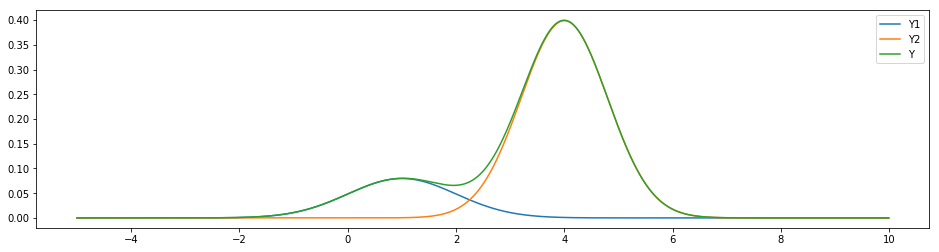

In [3]:
# plotting the pdf
import numpy as np
import matplotlib.pyplot as plt

plot_range = np.arange(-5,10,0.01)
pdf_Y1 = [((1.-pi_true)/(np.sqrt(2.*np.pi*stde_1_true**2.))) * 
          np.exp(-(x - mean_1_true)**2. / (2.*stde_1_true**2)) for x in plot_range]
pdf_Y2 = [(pi_true/(np.sqrt(2.*np.pi*stde_2_true**2.))) * 
          np.exp(-(x - mean_2_true)**2. / (2.*stde_2_true**2)) for x in plot_range]
pdf_Y = np.add(pdf_Y1,pdf_Y2)

plt.figure(figsize=(16,4))
plt.plot(plot_range,pdf_Y1, label="Y1")
plt.plot(plot_range,pdf_Y2, label="Y2")
plt.plot(plot_range,pdf_Y, label="Y")
plt.legend(loc="best")
plt.show()

# Generating samples

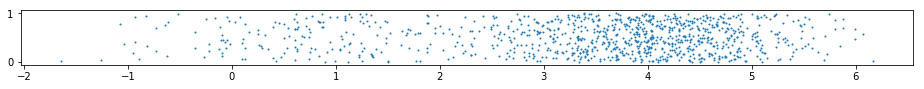

In [4]:
l = 1000
dot_size = 1.

samples = [stde_1_true*np.random.randn() + mean_1_true
           if np.random.random() > pi_true 
           else stde_2_true*np.random.randn() + mean_2_true
           for _ in range(l)]

plt.figure(figsize=(16,1))
plt.scatter(samples,np.random.random(l),s=dot_size)
plt.show()

Plotting histogram of samples

In [5]:
def plot_hist_pdf(samples_, pi_, mean_1_, mean_2_, stde_1_, stde_2_):
    plt.figure(figsize=(16,2))
    pdf_Y1 = [((1.-pi_)/(np.sqrt(2.*np.pi*stde_1_**2.))) * 
            np.exp(-(x - mean_1_)**2. / (2.*stde_1_**2)) for x in plot_range]
    pdf_Y2 = [(pi_/(np.sqrt(2.*np.pi*stde_2_**2.))) * 
            np.exp(-(x - mean_2_)**2. / (2.*stde_2_**2)) for x in plot_range]
    pdf_Y = np.add(pdf_Y1,pdf_Y2)
    plt.hist(samples, normed=True, bins=plot_range, color="orange")
    plt.plot(plot_range,pdf_Y1, label="Y1")
    plt.plot(plot_range,pdf_Y2, label="Y2")
    plt.plot(plot_range,pdf_Y, label="Y")
    plt.show()
    print("pi = {:.4f}, mean_1 = {:.4f}, mean_2 = {:.4f}, stde_1 = {:.4f}, stde_2 = {:.4f}"
      .format(pi_,mean_1_,mean_2_,stde_1_,stde_2_))
    
# making histograms take time
# https://stackoverflow.com/questions/44003552/matplotlib-histogram-from-numpy-histogram-output
# but this doesn't seem to be faster

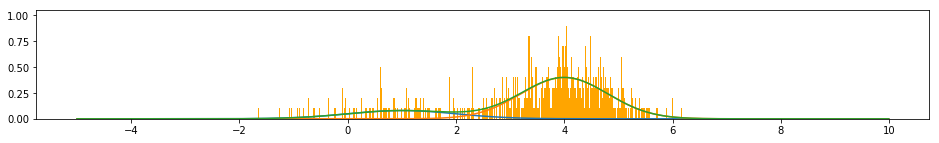

pi = 0.8000, mean_1 = 1.0000, mean_2 = 4.0000, stde_1 = 1.0000, stde_2 = 0.8000


In [6]:
plot_hist_pdf(samples, pi_true, mean_1_true, mean_2_true, stde_1_true, stde_2_true)

# Maximising w.r.t. $\{\pi , \mu_1, \sigma_1, \mu_2, \sigma_2\}$ 

We want to maximise this with respect to $\{\pi , \mu_1, \sigma_1, \mu_2, \sigma_2\}$:

$$\prod_i \left( 
\frac{1-\pi}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(\hat{x}_i - \mu_1)^2} {2 \sigma_1^2}}\right) 
+ \frac{\pi}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(\hat{x}_i - \mu_2)^2} {2 \sigma_2^2}}\right) 
\right) $$

It is better to minimise the negative log likelihood instead:

$$\ell(\theta,\mathbf{Z}) = \sum_i -log\left( 
\frac{1-\pi}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(\hat{x}_i - \mu_1)^2} {2 \sigma_1^2}}\right) 
+ \frac{\pi}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(\hat{x}_i - \mu_2)^2} {2 \sigma_2^2}}\right) 
\right) $$

We now calcalate log-likelihood w.r.t. ground truth for future reference.

In [7]:
def calc_nll(samples, pi_, mean_1_, mean_2_, stde_1_, stde_2_):
    l_ = len(samples)
    return -np.sum(
            np.log(
                (1-pi_)/(stde_1_*np.sqrt(2*np.pi))
                  *np.exp(-np.power(np.add(samples,[-mean_1_]*l_),2))/(2*stde_1_**2)
                + (pi_/(stde_2_*np.sqrt(2*np.pi)))
                  *np.exp(-np.power(np.add(samples,[-mean_2_]*l_),2))/(2*stde_2_**2)))

nll_true = calc_nll(samples, pi_true, mean_1_true, mean_2_true, stde_1_true, stde_2_true)

print("nll_true = {}".format(nll_true))

nll_true = 2155.96406927


# EM algorithm

We will need to start from a set of parameters to begin our parameters from. Perhaps we should use something that is reasonable. The initial mean for each of the distribution value should be slightly different from one another so they can start diverging.

$$\begin{align}
\hat{\mu}_1 &= +\epsilon + \frac{1}{N} \sum_{i=1}^N y_i \\
\hat{\sigma}_1 &= \sqrt{\frac{1}{N-1} \sum_{i=1}^N  (y_i - \hat{\mu}_2)^2} \\
\hat{\mu}_2 &= - \epsilon + \frac{1}{N} \sum_{i=1}^N y_i \\
\hat{\sigma}_2 &= \sqrt{\frac{1}{N-1} \sum_{i=1}^N  (y_i - \hat{\mu}_2)^2} \\
\hat{\pi} &= 0.5 
\end{align}$$

In [8]:
# # the five parameters
pi = 0.5  # probability if it lies from 
mean_1 = np.mean(samples) - np.std(samples)
stde_1 = np.std(samples) 
mean_2 = np.mean(samples) + np.std(samples)
stde_2 = np.std(samples)

# pi = 0.8  # probability if it lies from 
# mean_1 = 2.1
# stde_1 = 1.1
# mean_2 = 4.1
# stde_2 = 3.81

Updating the model (don't know how this is derived)

$$\begin{align}
\hat{\gamma}_i &= \frac{
\hat{\pi} \phi_{\hat{\theta}_2} ( y_i )
}{
(1 - \hat{\pi}) \phi_{\hat{\theta}_1} ( y_i ) + \hat{\pi} \phi_{\hat{\theta}_2} ( y_i )
} \\
\hat{\mu}_1 &= \frac{
\sum_{i=1}^N (1 - \hat{\gamma}_i) y_i
}{
\sum_{i=1}^N (1 - \hat{\gamma}_i)
} \\
\hat{\sigma}_1 &= \frac{
\sum_{i=1}^N (1 - \hat{\gamma}_i) (y_i - \hat{\mu}_2)^2
}{
\sum_{i=1}^N (1 - \hat{\gamma}_i)
} \\
\hat{\mu}_2 &= \frac{
\sum_{i=1}^N \hat{\gamma}_i y_i
}{
\sum_{i=1}^N \hat{\gamma}_i
} \\
\hat{\sigma}_2 &= \frac{
\sum_{i=1}^N \hat{\gamma}_i (y_i - \hat{\mu}_2)^2
}{
\sum_{i=1}^N \hat{\gamma}_i
} 
\end{align}$$

($\hat{\gamma}_i$ is analgous to $L_i$ with Numford's book)

# EM algorithm

In [9]:
# pi = 0.5  # probability if it lies from 
# mean_1 = 1.1
# stde_1 = 0.4
# mean_2 = 5.
# stde_2 = 1.55

In [10]:
pi_list = [pi]
mean_1_list = [mean_1]
stde_1_list = [stde_1]
mean_2_list = [mean_2]
stde_2_list = [stde_2]
nll = calc_nll(samples, pi, mean_1, mean_2, stde_1, stde_2)
nll_list = [nll]

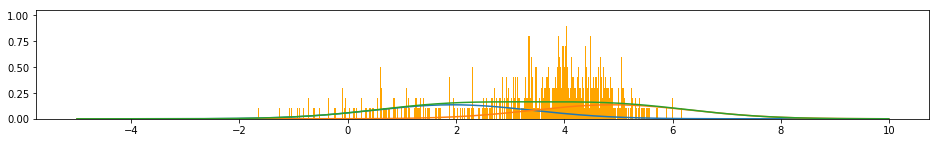

pi = 0.5000, mean_1 = 1.9371, mean_2 = 4.8870, stde_1 = 1.4750, stde_2 = 1.4750
interation 0, nll = 4381.34933764


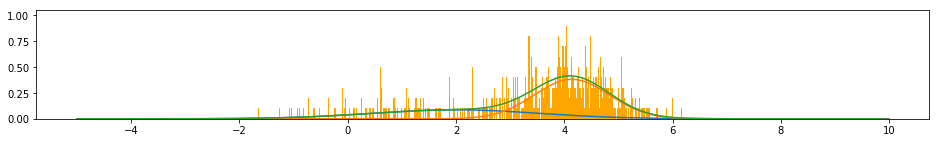

pi = 0.6618, mean_1 = 1.9868, mean_2 = 4.1402, stde_1 = 1.5569, stde_2 = 0.6931
interation 10, nll = 2360.93918608


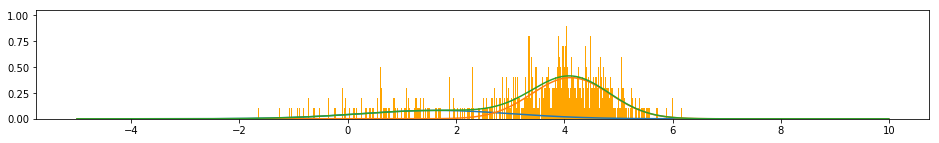

pi = 0.7169, mean_1 = 1.6313, mean_2 = 4.1153, stde_1 = 1.3965, stde_2 = 0.7193
interation 20, nll = 2229.64020581


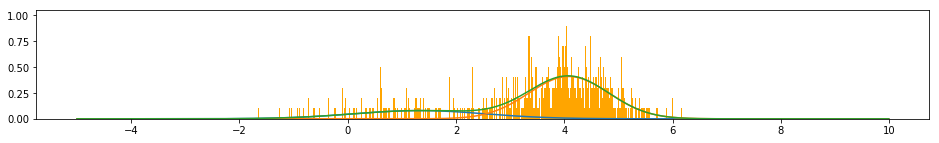

pi = 0.7575, mean_1 = 1.3201, mean_2 = 4.0818, stde_1 = 1.2194, stde_2 = 0.7391
interation 30, nll = 2126.60409436


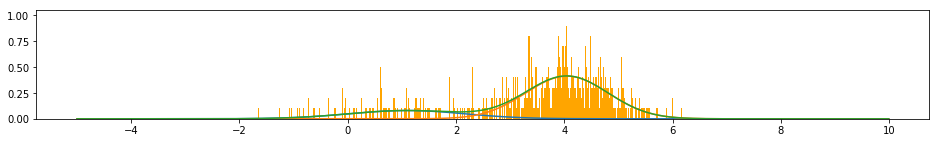

pi = 0.7853, mean_1 = 1.0884, mean_2 = 4.0474, stde_1 = 1.0711, stde_2 = 0.7594
interation 40, nll = 2077.82632179


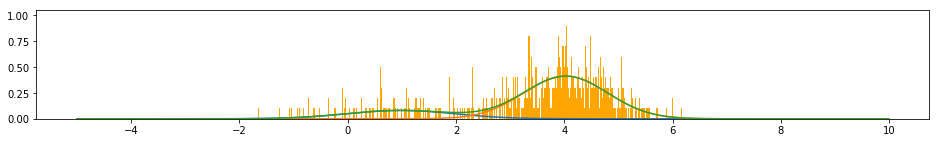

pi = 0.7984, mean_1 = 0.9760, mean_2 = 4.0273, stde_1 = 0.9951, stde_2 = 0.7730
interation 50, nll = 2068.37816095


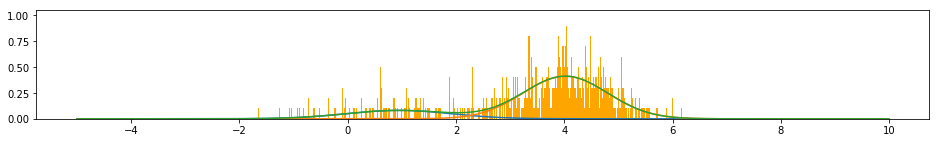

pi = 0.8026, mean_1 = 0.9397, mean_2 = 4.0202, stde_1 = 0.9702, stde_2 = 0.7782
interation 60, nll = 2068.12194957


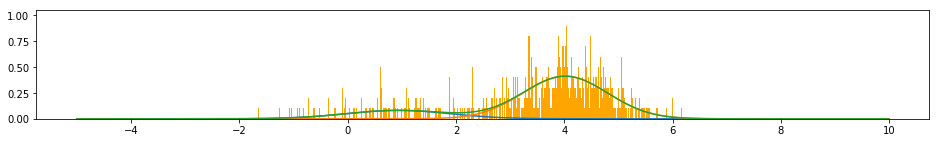

pi = 0.8037, mean_1 = 0.9300, mean_2 = 4.0182, stde_1 = 0.9635, stde_2 = 0.7797
interation 70, nll = 2068.33500897


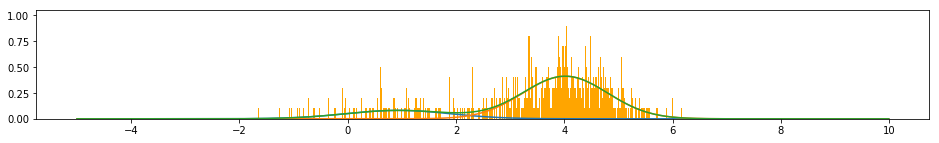

pi = 0.8040, mean_1 = 0.9276, mean_2 = 4.0178, stde_1 = 0.9619, stde_2 = 0.7801
interation 80, nll = 2068.40819554


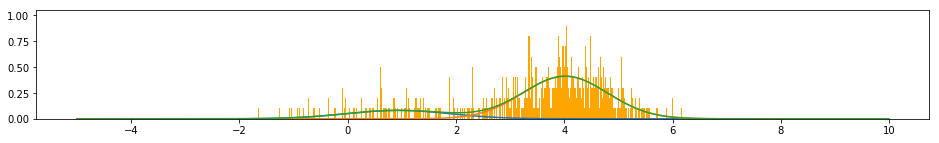

pi = 0.8041, mean_1 = 0.9270, mean_2 = 4.0176, stde_1 = 0.9614, stde_2 = 0.7802
interation 90, nll = 2068.42746304


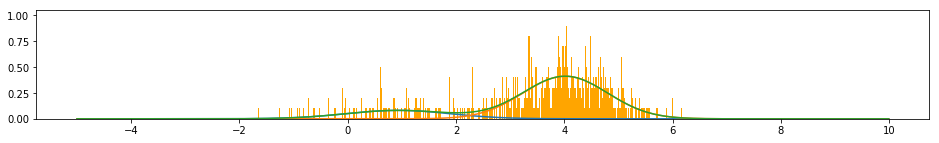

pi = 0.8041, mean_1 = 0.9268, mean_2 = 4.0176, stde_1 = 0.9613, stde_2 = 0.7802
interation 100, nll = 2068.43226427


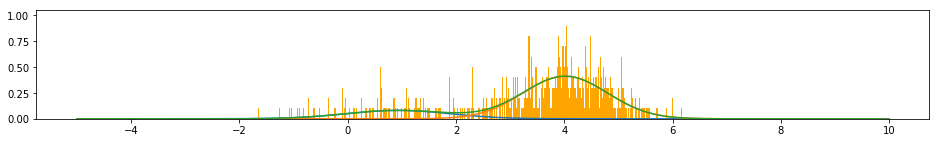

pi = 0.8041, mean_1 = 0.9268, mean_2 = 4.0176, stde_1 = 0.9613, stde_2 = 0.7802
interation 110, nll = 2068.43344525


In [11]:
iterations = 120
plotting = False
for x in range(iterations):
    
    if x%10 == 0:
        plot_hist_pdf(samples, pi, mean_1, mean_2, stde_1, stde_2)
        print("interation {}, nll = {}".format(x, nll))
    
    odds_Y1 = [((1-pi)/(stde_1*np.sqrt(2*np.pi))) 
                * np.exp(-(x - mean_1)**2. / (2. * stde_1**2)) for x in samples]
    odds_Y2 = [((pi)/(stde_2*np.sqrt(2*np.pi))) 
                * np.exp(-(x - mean_2)**2. / (2. * stde_2**2)) for x in samples]
    gamma_i = np.divide(odds_Y2,np.add(odds_Y1,odds_Y2))
    gamma_1_i = np.divide(odds_Y1,np.add(odds_Y1,odds_Y2))
    
    pi = np.sum(gamma_i)/l
    mean_1 = np.sum(np.multiply(gamma_1_i,samples)) / np.sum(gamma_1_i)
    mean_2 = np.sum(np.multiply(gamma_i,samples)) / np.sum(gamma_i)
    stde_1 = np.sqrt(np.sum(np.multiply(gamma_1_i,
                            np.power(np.add(samples,[-mean_1]*l),2)))/np.sum(gamma_1_i))
    stde_2 = np.sqrt(np.sum(np.multiply(gamma_i,
                            np.power(np.add(samples,[-mean_2]*l),2)))/np.sum(gamma_i))

    
    pi_list.append(pi)
    mean_1_list.append(mean_1)
    stde_1_list.append(stde_1)
    mean_2_list.append(mean_2)
    stde_2_list.append(stde_2)
    nll = calc_nll(samples, pi, mean_1, mean_2, stde_1, stde_2)
    nll_list.append(nll)
    


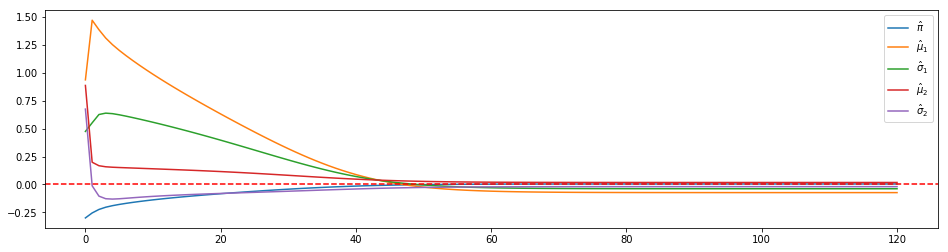

In [12]:
plt.figure(figsize=(16,4))
plt.plot(np.add(pi_list,-pi_true), label="$\hat{\pi}$")
plt.plot(np.add(mean_1_list,-mean_1_true), label="$\hat{\mu}_1$")
plt.plot(np.add(stde_1_list,-stde_1_true), label="$\hat{\sigma}_1$")
plt.plot(np.add(mean_2_list,-mean_2_true), label="$\hat{\mu}_2$")
plt.plot(np.add(stde_2_list,-stde_2_true), label="$\hat{\sigma}_2$")
plt.axhline(y=0, color='r', linestyle='--')
plt.legend(loc="best")
plt.show()

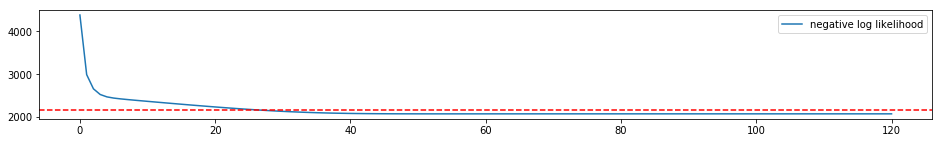

In [13]:
plt.figure(figsize=(16,2))
plt.plot(nll_list, label="negative log likelihood")
plt.legend(loc="best")
plt.axhline(y=nll_true, color='r', linestyle='--')
plt.show()

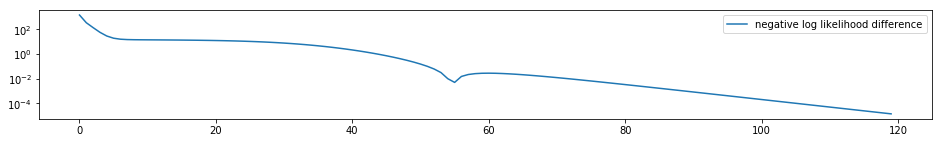

In [14]:
plt.figure(figsize=(16,2))
plt.semilogy(np.abs(np.diff(nll_list)), 
             label="negative log likelihood difference")
plt.legend(loc="best")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()